# ART BY AI 

after reading the 'ART BY AI ' document , now you can move to the code of this project 

first of all import the needed libraries  

In [1]:
import tensorflow 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import tensorflow_hub as hub
import cv2

2023-01-16 19:45:33.508524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model 1 : 

    cartoon photos :

defined the constants at the hole project 

In [2]:
IMG_HEIGHT = 400
IMG_WIDTH = 400
IMG_CHANNELS = 3
SAMPLE_SIZE = 9000
BATCH_SIZE = 5
LEARNING_RATE = 0.001
IMG_DTYPE = 'int32'


list the directory that contains the data where the data is 

In [4]:
art_images_list = os.listdir('/Users/adeella/Desktop/model2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics')

in this step we will save the images name in CSV file :

    1- Train CSV
    2- Validation CSV
    3- Test CSV

In [6]:
#pic random nubers for test images 
test_id_list = ['180.jpg',
 '1803.jpg',
 '1390.jpg',
 '434.jpg',
 '315.jpg',
 '106.jpg',
 '1166.jpg',
 '1358.jpg',
 '339.jpg',
 '47.jpg']

#Save the numbers in Data frame under " image_id" column
df_art = pd.DataFrame(art_images_list, columns=['image_id'])

#make data frame from the test list under 'image_id' column
df_test = pd.DataFrame(test_id_list, columns=['image_id'])
df_test = df_test.reset_index(drop=True)


#remove the tests images from the rest of data
df_data = df_art[~df_art['image_id'].isin(test_id_list)]


print(df_data.shape)
print(df_test.shape)

#Split the data to train data and validation data 
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=42)


# reset the index
df_train5 = df_train.reset_index(drop=True)
df_val5 = df_val.reset_index(drop=True)
df_test5 = df_test.reset_index(drop=True)

print(df_train5.shape)
print(df_val5.shape)
print(df_test5.shape)

df_train5.to_csv('df_train6.csv')
df_val5.to_csv('df_val6.csv')
df_test5.to_csv('df_test6.csv')




(9991, 1)
(10, 1)
(8991, 1)
(1000, 1)
(10, 1)


now we make function to generate Train data :

1) X_train :

make counter to read the images from directory , resize it , flib it ,then save the matrix 

2) Y_train :

make counter to read the images from directory , resize it , flib it ,then save the matrix 

In [7]:

def train_generator(batch_size=5):
    
    while True:
        
        for df in pd.read_csv('df_train6.csv', chunksize=batch_size):
            
            # get the list of portrait images
            image_id_list = list(df['image_id'])
            # get list of art images
            art_id_list = list(df['image_id'])
            
            
            # create an empty matrix
            X_orig = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)
            X_hflip = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)


            for i, image_id in enumerate(image_id_list):

                # set the path to the image
                path = '/Users/adeella/Desktop/model2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/'+ image_id

                # image as an array
                image = plt.imread(path)
                # resize the image 400x400
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                
                # original image
                X_orig[i] = image
                # flip image horizontally
                X_hflip[i] = np.fliplr(image)

                # stack the matrices to form X_train
                X_train = np.vstack((X_orig, X_hflip))

            
            
            # Y_train
            # =========
            
            
            # create an empty matrix
            Y_orig = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)
            Y_hflip = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)


            for i, image_id in enumerate(art_id_list):

                # set the path to the image
                path = '/Users/adeella/Desktop/model2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics/' + image_id

                # read the file as an array
                #image = imread(path)
                # read the image using skimage
                image = imread(path)
                # resize the image
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                
                # original image
                Y_orig[i] = image
                # flip image horizontally
                Y_hflip[i] = np.fliplr(image)

                # stack the matrices to form Y_train
                Y_train = np.vstack((Y_orig, Y_hflip))
        
        
            yield X_train, Y_train
            

(10, 400, 400, 3)
(10, 400, 400, 3)


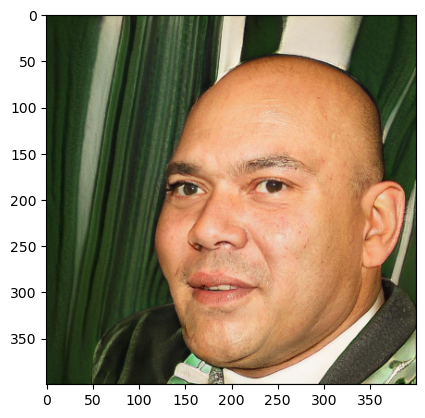

In [14]:
train_gen = train_generator(batch_size=5)
X_train, Y_train = next(train_gen)
print(X_train.shape)
print(Y_train.shape)

img1 = X_train[0,:,:,:]
img2 = Y_train[0,:,:,:]
plt.imshow(img1)



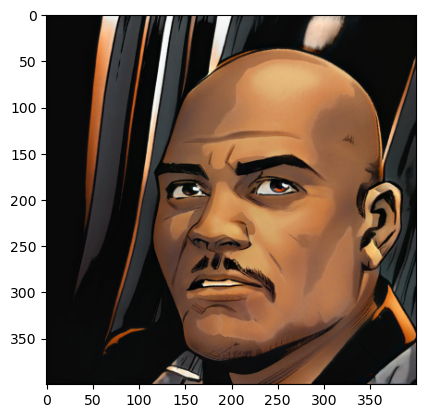

In [13]:
plt.imshow(img2)

now we make function to generate Validation data :

1) X_val :

make counter to read the images from directory , resize it ,then save the matrix 

2) Y_val :

make counter to read the images from directory , resize it ,then save the matrix 

In [16]:
def val_generator(batch_size=5):
    
    while True:
        
        for df in pd.read_csv('df_val6.csv', chunksize=batch_size):
            
            # get the list of portrait images
            image_id_list = list(df['image_id'])
            # get list of art images
            art_id_list = list(df['image_id'])
            
            
            # X_val
            # =========
            
            # create an empty matrix
            X_val = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)


            for i, image_id in enumerate(image_id_list):

                # select the folder_id from the list
                folder_id = image_id

                # set the path to the image
                path = '/Users/adeella/Desktop/model2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/'+ image_id

                #read the image as an array
                image = plt.imread(path)
                # resize the image
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                # insert the image into X_val
                X_val[i] = image
                
            
            
            # Y_val
            # =========
            
            
            # create an empty matrix
            Y_val = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)


            for i, image_id in enumerate(art_id_list):

                # set the path to the image
                path = '/Users/adeella/Desktop/model2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics/' + image_id

                # read the image as an array
                image = imread(path)
                # resize the image
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                Y_val[i] = image
        
        
            yield X_val, Y_val
            
     

(5, 400, 400, 3)
(5, 400, 400, 3)


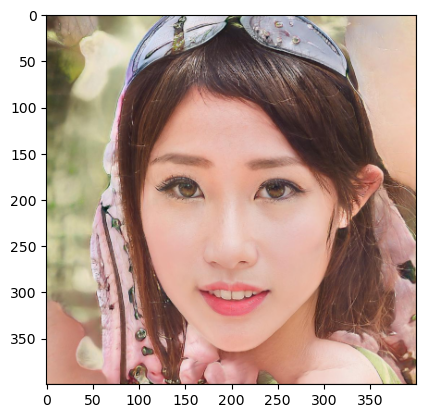

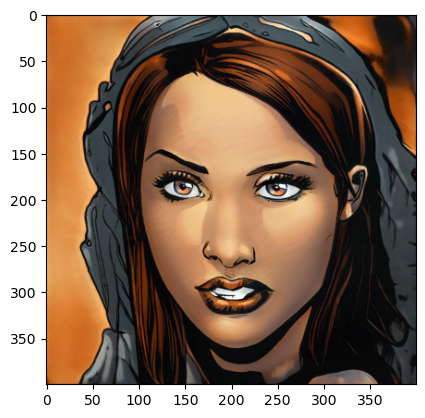

In [17]:
val_gen = val_generator(batch_size=5)

X_val, Y_val = next(val_gen)

print(X_val.shape)
print(Y_val.shape)

img = X_val[0,:,:,:]
plt.imshow(img)

plt.show()

img = Y_val[0,:,:,:]
plt.imshow(img)

plt.show()


now we make function to generate Test data :

X_test :

make counter to read the images from directory , resize it ,then save the matrix 


In [21]:

def test_generator(batch_size=1):
    
    while True:
        
        for df in pd.read_csv('df_test6.csv', chunksize=batch_size):
            
            # get the list of portrait images
            image_id_list = list(df['image_id'])
            
            
            # X_test
            # =========
            
            # create an empty matrix
            X_test = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)


            for i, image_id in enumerate(image_id_list):

                # select the folder_id from the list
                folder_id = image_id

                # set the path to the image
                path = '/Users/adeella/Desktop/model2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/' + image_id

                # read the file as an array
                image = imread(path)
                # resize the image
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)


                # insert the image into X_test
                X_test[i] = image
                
            
            yield X_test
            



(1, 400, 400, 3)


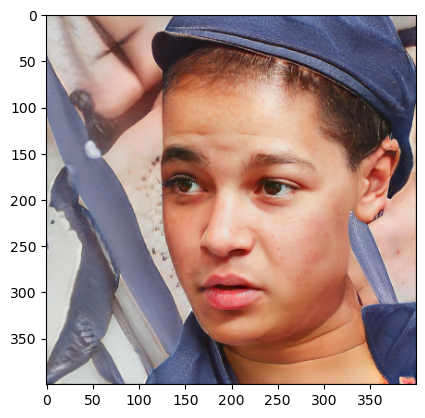

In [22]:
test_gen = test_generator(batch_size=1)
X_test = next(test_gen)
print(X_test.shape)
img = X_test[0,:,:,:]
plt.imshow(img)

plt.show()


Then bulid the model as we descused in the document 

In [38]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)

outputs = Conv2D(3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

model = Model(inputs=[inputs], outputs=[outputs])


model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 400, 400, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 400, 400, 16  0           ['conv2d_18[0][0]']              
                                )                                                           

In [39]:
train_gen = train_generator(batch_size=BATCH_SIZE)
val_gen = val_generator(batch_size=BATCH_SIZE)


model.compile(Adam(lr=LEARNING_RATE), loss='mean_squared_error')


Run the model now 

In [163]:

history = model.fit_generator(train_gen, steps_per_epoch=1620, epochs=30, validation_data=val_gen, validation_steps=200,verbose=1)



Epoch 1/30
1620/1620 [==============================] - 8675s 5s/step - loss: 1395.1608 - val_loss: 1447.4061
Epoch 2/30
1620/1620 [==============================] - 8343s 5s/step - loss: 1384.3771 - val_loss: 1447.1896
Epoch 3/30
1620/1620 [==============================] - 8389s 5s/step - loss: 1374.4375 - val_loss: 1410.3589
Epoch 4/30
1620/1620 [==============================] - 8250s 5s/step - loss: 1361.8396 - val_loss: 1398.8870
Epoch 5/30
1620/1620 [==============================] - 8315s 5s/step - loss: 1350.2432 - val_loss: 1394.1311
Epoch 6/30
1620/1620 [==============================] - 8332s 5s/step - loss: 1343.2660 - val_loss: 1394.0995
Epoch 7/30
1620/1620 [==============================] - 8408s 5s/step - loss: 1332.2810 - val_loss: 1379.7666
Epoch 8/30
1620/1620 [==============================] - 8269s 5s/step - loss: 1326.0336 - val_loss: 1393.2322
Epoch 9/30
1620/1620 [==============================] - 8254s 5s/step - loss: 1317.0397 - val_loss: 1376.3165
Epoch 10/3

In [174]:
           
test_gen = test_generator(batch_size=10)
X_test = next(test_gen)
preds = model.predict_generator(test_gen, 
                                steps=10, 
                                verbose=1)



10/10 [==============================] - 16s 2s/step


predict the test photos :

243
0


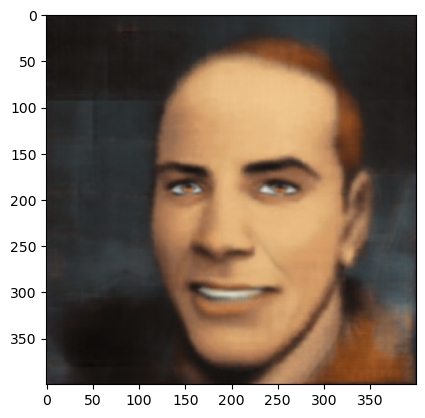

In [188]:
print(preds.max())
print(preds.min())
preds = np.clip(preds, 0, 255).astype(IMG_DTYPE)
image = preds[1]
plt.imshow(image)


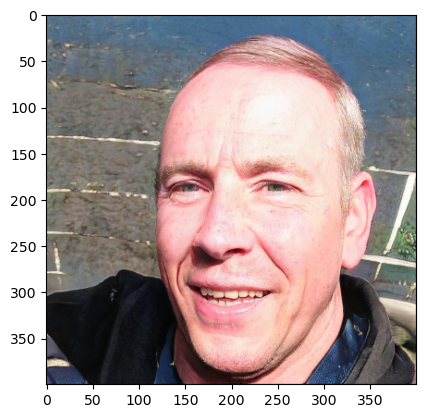

In [187]:
img = X_test[1,:,:,:]
plt.imshow(img)

plot the trainig loss and validation loss  :

<Figure size 640x480 with 0 Axes>

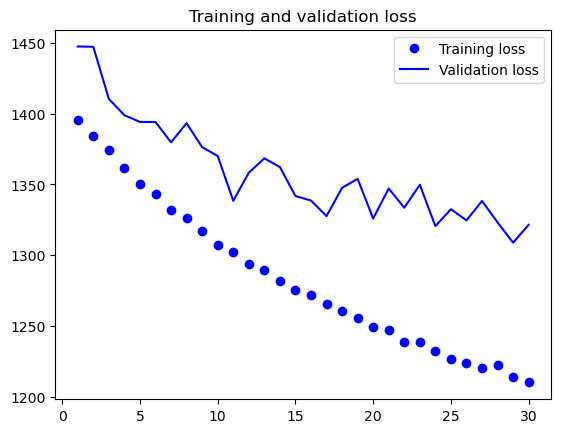

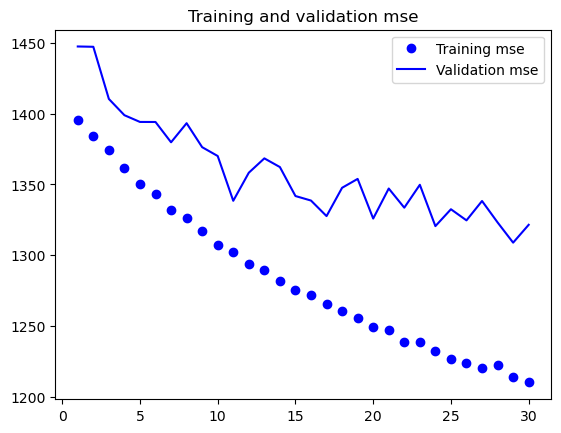

<Figure size 640x480 with 0 Axes>

In [172]:
import matplotlib.pyplot as plt

mean_squared_error = history.history['loss']
val_mean_squared_error = history.history['val_loss']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mean_squared_error) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, mean_squared_error, 'bo', label='Training mse')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.figure()


I loaded some photos from internet and test them :

In [201]:

test_id_list11 = [
 '434.jpg',
 '315.jpg',
 '339.jpg']


In [202]:
df_test2 = pd.DataFrame(test_id_list11, columns=['image_id'])
df_test2 = df_test2.reset_index(drop=True)
df_test2.to_csv('df_test11.csv')


In [203]:
def test_generator(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches) from  ** df_test.csv.gz **
        for df in pd.read_csv('df_test11.csv', chunksize=batch_size):
            
            # get the list of portrait images
            image_id_list = list(df['image_id'])
            
            
            # X_test
            # =========
            
            # create an empty matrix
            X_test = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='uint8')


            for i, image_id in enumerate(image_id_list):

                # select the folder_id from the list
                

                # set the path to the image
                path = '/Users/adeella/Desktop/untitled folder/'+ image_id

                # read the file as an array
                image = imread(path)
                # resize the image
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)


                # insert the image into X_test
                X_test[i] = image
                
            
            yield X_test
            
test_gen2 = test_generator(batch_size=1)
X_test = next(test_gen2)
preds = model.predict_generator(test_gen2, 
                                steps=5, 
                                verbose=1)




5/5 [==============================] - 1s 135ms/step


254
0


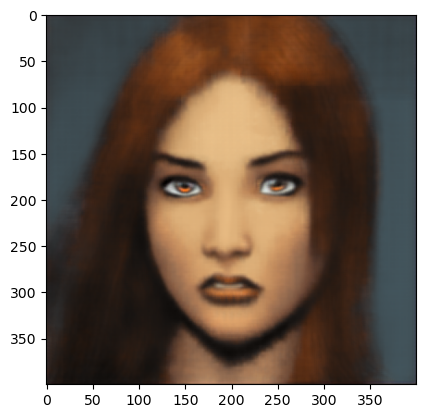

In [211]:


print(preds.max())
print(preds.min())
preds = np.clip(preds, 0,300).astype('uint32')
image = preds[1]
plt.imshow(image)


model 2 :
    
    50% cartoon 

repeat the same procces but the data will change :

In [212]:
test_id_listB = ['180.jpg',
 '1803.jpg',
 '1390.jpg',
 '434.jpg',
 '315.jpg',
 '106.jpg',
 '1166.jpg',
 '1358.jpg',
 '339.jpg',
 '47.jpg']


# Load the list of art images in the Art by Ai dataset
art_images_listB = os.listdir('/Users/adeella/Desktop/model3/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/comics')

# create a data frame with the file names of all art images
df_artB = pd.DataFrame(art_images_listB, columns=['image_id'])

# create a test dataframe
df_testB = pd.DataFrame(test_id_listB, columns=['image_id'])

# Reset the index.
df_testB = df_testB.reset_index(drop=True)


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_dataB = df_artB[~df_artB['image_id'].isin(test_id_listB)]


print(df_dataB.shape)
print(df_testB.shape)

(9990, 1)
(10, 1)


In [213]:

df_trainB, df_valB = train_test_split(df_dataB, test_size=0.10, random_state=42)


# reset the index
df_trainB = df_trainB.reset_index(drop=True)
df_valB = df_valB.reset_index(drop=True)
df_testB = df_testB.reset_index(drop=True)

print(df_trainB.shape)
print(df_valB.shape)
print(df_testB.shape)

df_trainB.to_csv('df_trainB.csv')
df_valB.to_csv('df_valB.csv')
df_testB.to_csv('df_testB.csv')



(8991, 1)
(999, 1)
(10, 1)


(10, 400, 400, 3)
(10, 400, 400, 3)


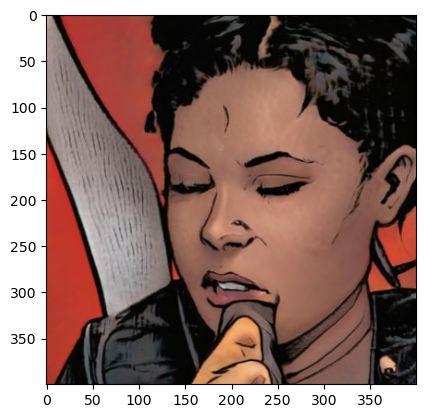

In [217]:

def train_generatorB(batch_size=5):
    
    while True:
        
        # load the data in chunks (batches) from  ** df_train.csv.gz **
        for df_B in pd.read_csv('df_trainB.csv', chunksize=batch_size):
            
            # get the list of portrait images
            image_id_listB = list(df_B['image_id'])
            # get list of art images
            art_id_listB = list(df_B['image_id'])
            
            
            # X_train
            # =========
            
            # create an empty matrix
            X_origB = np.zeros((len(df_B), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)
            X_hflipB = np.zeros((len(df_B), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)


            for i_B, image_id in enumerate(image_id_listB):

                # select the folder_id from the list
                folder_idB = image_id

                # set the path to the image
                pathB = '/Users/adeella/Desktop/model3/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/face/'+ image_id

                # read the file as an array
                imageB = plt.imread(pathB)
                # resize the image
                imageB = resize(imageB, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                
                # original image
                X_origB[i_B] = imageB
                # flip image horizontally
                X_hflipB[i_B] = np.fliplr(imageB)

                # stack the matrices to form X_train
                X_trainB = np.vstack((X_origB, X_hflipB))

            
            
            # Y_train
            # =========
            
            
            # create an empty matrix
            Y_origB = np.zeros((len(df_B), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)
            Y_hflipB = np.zeros((len(df_B), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)


            for i_B, image_id in enumerate(art_id_listB):

                # set the path to the image
                pathB = '/Users/adeella/Desktop/model3/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/comics/' + image_id

                # read the file as an array
                #image = imread(path)
                # read the image using skimage
                imageB = imread(pathB)
                # resize the image
                imageB = resize(imageB, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                
                # original image
                Y_origB[i_B] = imageB
                # flip image horizontally
                Y_hflipB[i_B] = np.fliplr(imageB)

                # stack the matrices to form Y_train
                Y_trainB = np.vstack((Y_origB, Y_hflipB))
        
        
            yield X_trainB, Y_trainB
            
train_genB = train_generatorB(batch_size=5)
X_trainB, Y_trainB = next(train_genB)
print(X_trainB.shape)
print(Y_trainB.shape)

imgB = X_trainB[0,:,:,:]
plt.imshow(imgB)

imgB = Y_trainB[0,:,:,:]
plt.imshow(imgB)

(5, 400, 400, 3)
(5, 400, 400, 3)


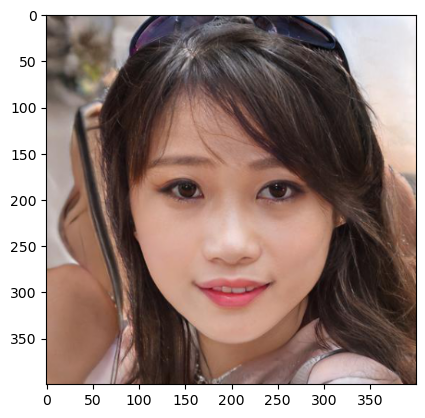

In [220]:
def val_generatorB(batch_size=5):
    
    while True:
        
        # load the data in chunks (batches) from  ** df_val.csv.gz **
        for df_B in pd.read_csv('df_valB.csv', chunksize=batch_size):
            
            # get the list of portrait images
            image_id_listB = list(df_B['image_id'])
            # get list of art images
            art_id_listB = list(df_B['image_id'])
            
            
            # X_val
            # =========
            
            # create an empty matrix
            X_valB = np.zeros((len(df_B), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)


            for i_B, image_id in enumerate(image_id_listB):

                # select the folder_id from the list
                folder_idB = image_id

                # set the path to the image
                pathB = '/Users/adeella/Desktop/model3/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/face/'+ image_id

                # read the file as an array
                imageB = plt.imread(pathB)
                # resize the image
                imageB = resize(imageB, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)


                # insert the image into X_val
                X_valB[i_B] = imageB
                
            
            
            # Y_val
            # =========
            
            
            # create an empty matrix
            Y_valB = np.zeros((len(df_B), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)


            for i_B, image_id in enumerate(art_id_listB):

                # set the path to the image
                pathB = '/Users/adeella/Desktop/model3/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/comics/' + image_id

                # read the file as an array
                #image = imread(path)
                # read the image using skimage
                imageB = imread(pathB)
                # resize the image
                imageB = resize(imageB, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

                # insert the image into X_val
                Y_valB[i_B] = imageB
        
        
            yield X_valB, Y_valB
            
     

val_genB = val_generatorB(batch_size=5)

X_valB, Y_valB = next(val_genB)

print(X_valB.shape)
print(Y_valB.shape)

imgB = X_valB[0,:,:,:]
plt.imshow(imgB)



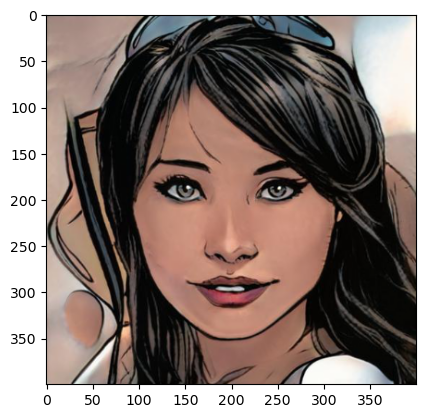

In [221]:
imgB = Y_valB[0,:,:,:]
plt.imshow(imgB)

(1, 400, 400, 3)


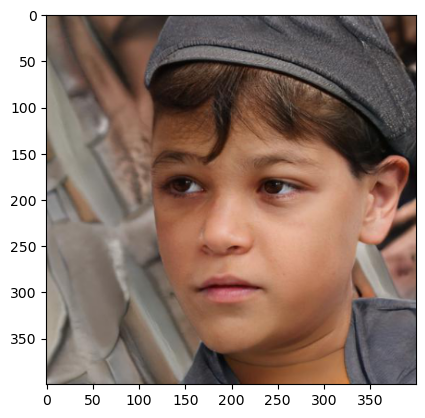

In [223]:
def test_generatorB(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches) from  ** df_test.csv.gz **
        for df_B in pd.read_csv('df_testB.csv', chunksize=batch_size):
            
            # get the list of portrait images
            image_id_listB = list(df_B['image_id'])
            
            
            # X_test
            # =========
            
            # create an empty matrix
            X_testB = np.zeros((len(df_B), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='uint8')


            for i_B, image_id in enumerate(image_id_listB):

                # select the folder_id from the list
                folder_idB = image_id

                # set the path to the image
                pathB = '/Users/adeella/Desktop/model3/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/face/' + image_id

                # read the file as an array
                imageB = imread(pathB)
                # resize the image
                imageB = resize(imageB, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)


                # insert the image into X_test
                X_testB[i_B] = imageB
                
            
            yield X_testB
            

test_genB = test_generatorB(batch_size=1)
X_testB = next(test_genB)
print(X_testB.shape)
imgB = X_testB[0,:,:,:]
plt.imshow(imgB)




In [235]:
modelB = Model(inputs=[inputs], outputs=[outputs])


modelB.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_180 (Conv2D)            (None, 400, 400, 16  448         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_90 (Dropout)           (None, 400, 400, 16  0           ['conv2d_180[0][0]']             
                                )                                                           

In [237]:
modelB.compile(Adam(lr=LEARNING_RATE), loss='mean_squared_error')


historyB = modelB.fit_generator(train_genB, steps_per_epoch=1000, epochs=20, validation_data=val_genB, validation_steps=50,verbose=1)




Epoch 1/20
1000/1000 [==============================] - 4581s 5s/step - loss: 1703.4167 - val_loss: 1506.8173
Epoch 2/20
1000/1000 [==============================] - 4472s 4s/step - loss: 1513.2280 - val_loss: 1415.2037
Epoch 3/20
1000/1000 [==============================] - 4578s 5s/step - loss: 1439.2556 - val_loss: 1458.9956
Epoch 4/20
1000/1000 [==============================] - 4386s 4s/step - loss: 1402.5986 - val_loss: 1441.1879
Epoch 5/20
1000/1000 [==============================] - 4495s 4s/step - loss: 1367.0544 - val_loss: 1357.8290
Epoch 6/20
1000/1000 [==============================] - 4719s 5s/step - loss: 1338.8999 - val_loss: 1286.4268
Epoch 7/20
1000/1000 [==============================] - 4793s 5s/step - loss: 1318.7021 - val_loss: 1340.4860
Epoch 8/20
1000/1000 [==============================] - 4790s 5s/step - loss: 1296.4937 - val_loss: 1321.4172
Epoch 9/20
1000/1000 [==============================] - 4796s 5s/step - loss: 1286.6694 - val_loss: 1366.3024
Epoch 10/2

10/10 [==============================] - 1s 135ms/step


243.0007
4.539354
243
4


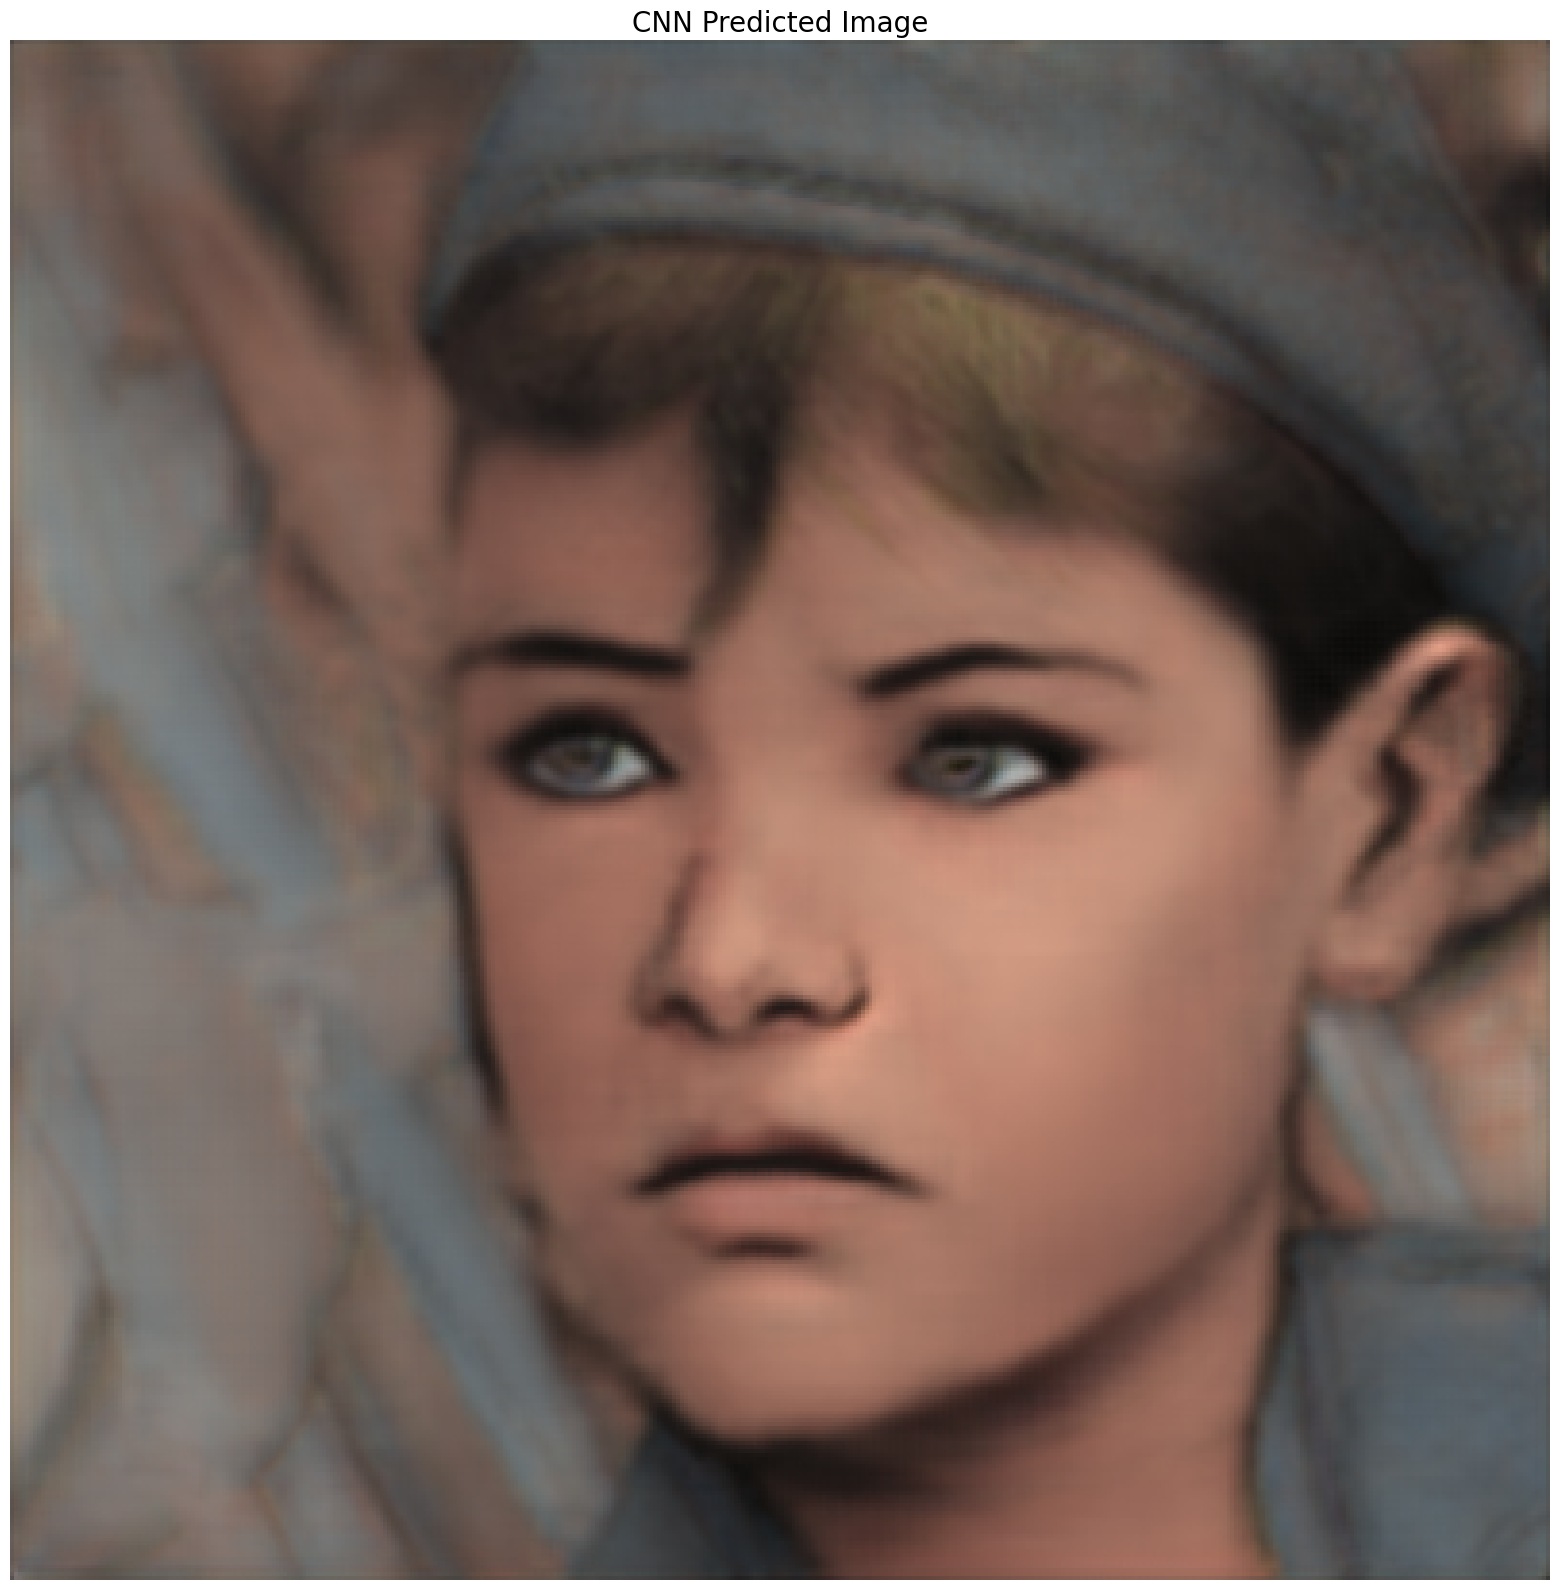

In [259]:


# initialize the test generator
test_genB = test_generatorB(batch_size=1)


predsB = modelB.predict_generator(test_genB, 
                                steps=len(df_testB), 
                                verbose=1)

# check the max and min predicted pixel values
print('\n')
print(predsB.max())
print(predsB.min())

predsB = np.clip(predsB, 0, 255).astype(IMG_DTYPE)


# check the max and min predicted pixel values again
print(predsB.max())
print(predsB.min())
######


# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.axis('Off')



imageB = predsB[0]
plt.imshow(imageB)
plt.title('CNN Predicted Image', fontsize=20)
plt.axis('off')

plt.show()#



Load photos from internet 

In [260]:

test_id_listBB = [
 '434.jpg',
 '315.jpg',
 '339.jpg']


In [261]:
df_testBB = pd.DataFrame(test_id_listBB, columns=['image_id'])
df_testBB = df_testBB.reset_index(drop=True)
df_testBB.to_csv('df_testBB.csv')


In [264]:
def test_generatorBB(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches) from  ** df_test.csv.gz **
        for dfBB in pd.read_csv('df_testBB.csv', chunksize=batch_size):
            
            # get the list of portrait images
            image_id_listBB = list(dfBB['image_id'])
            
            
            # X_test
            # =========
            
            # create an empty matrix
            X_testBB = np.zeros((len(dfBB), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype='uint8')


            for iB, image_id in enumerate(image_id_listBB):

                # select the folder_id from the list
                

                # set the path to the image
                pathBB = '/Users/adeella/Desktop/untitled folder/'+ image_id

                # read the file as an array
                imageBB = imread(pathBB)
                # resize the image
                imageBB = resize(imageBB, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)


                # insert the image into X_test
                X_testBB[iB] = imageBB
                
            
            yield X_testBB
            
test_genBB= test_generatorBB(batch_size=1)
X_testBB = next(test_genBB)
predsBB = modelB.predict_generator(test_genBB, 
                                steps=5, 
                                verbose=1)




5/5 [==============================] - 1s 135ms/step




227
0
227
0


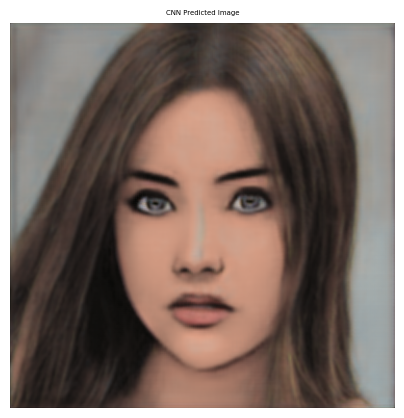

In [273]:

# check the max and min predicted pixel values
print('\n')
print(predsBB.max())
print(predsBB.min())

predsBB = np.clip(predsBB, 0, 255).astype(IMG_DTYPE)


# check the max and min predicted pixel values again
print(predsBB.max())
print(predsBB.min())
######


# set up the canvas for the subplots
plt.figure(figsize=(5,5))
plt.axis('Off')



imageBB = predsBB[4]
plt.imshow(imageBB)
plt.title('CNN Predicted Image', fontsize=5)
plt.axis('off')

plt.show()#



Model 3:
    
    convert photo to art 

the same model is used 

In [24]:

test_id_listC = ['1803232244-00000007.jpg',
 '1803261926-00000039.jpg',
 '1803281444-00000390.jpg',
 '1803261926-00000434.jpg',
 '1803250811-00000315.jpg',
 '1803261926-00000106.jpg',
 '1803281444-00000166.jpg',
 '1803250811-00000358.jpg',
 '1803250811-00000339.jpg',
 '1803250936-00000547.jpg']


art_images_listC = os.listdir('/Users/adeella/Desktop/project/art-by-ai-neural-style-transfer/content_images/content_images')

# create a data frame with the file names of all art images
df_artC = pd.DataFrame(art_images_listC, columns=['image_id'])

# create a test dataframe
df_testC = pd.DataFrame(test_id_listC, columns=['image_id'])

# Reset the index.
df_testC = df_testC.reset_index(drop=True)


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_dataC = df_artC[~df_artC['image_id'].isin(test_id_listC)]


# Reduce the number of rows of df_data to speed up training.
# Choose a random sample of rows.
df_dataC = df_dataC.sample(SAMPLE_SIZE, random_state=42)

df_trainC, df_valC = train_test_split(df_dataC, test_size=0.10, random_state=101)


# reset the index
df_trainC = df_trainC.reset_index(drop=True)
df_valC = df_valC.reset_index(drop=True)
df_testC = df_testC.reset_index(drop=True)

df_trainC.to_csv('df_trainC.csv')
df_valC.to_csv('df_valC.csv')
df_testC.to_csv('df_testC.csv')


In [275]:

def train_generatorC(batch_size=5):
    
    while True:
        
        # load the data in chunks (batches) from  ** df_train.csv.gz **
        for dfC in pd.read_csv('df_trainC.csv', chunksize=batch_size):
            
            # get the list of portrait images
            image_id_listC = list(dfC['image_id'])
            # get list of art images
            art_id_listC = list(dfC['image_id'])
            
            
            # X_train
            # =========
            
            # create an empty matrix
            X_origC = np.zeros((len(dfC), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)
            X_hflipC = np.zeros((len(dfC), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)


            for iC, image_id in enumerate(image_id_listC):

                # select the folder_id from the list
                folder_idC = image_id.split('-')[0]

                # set the path to the image
                pathC = '/Users/adeella/Desktop/project/aisegmentcom-matting-human-datasets/matting_human_half/clip_img/' + \
                str(folder_idC) + '/clip_00000000/' + image_id

                # read the file as an array
                imageC = plt.imread(pathC)
                # resize the image
                imageC = resize(imageC, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                
                # original image
                X_origC[iC] = imageC
                # flip image horizontally
                X_hflipC[iC] = np.fliplr(imageC)

                # stack the matrices to form X_train
                X_trainC = np.vstack((X_origC, X_hflipC))

            
            
            # Y_train
            # =========
            
            
            # create an empty matrix
            Y_origC = np.zeros((len(dfC), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)
            Y_hflipC = np.zeros((len(dfC), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)


            for iC, image_id in enumerate(art_id_listC):

                # set the path to the image
                pathC = '/Users/adeella/Desktop/project/art-by-ai-neural-style-transfer/content_images/content_images/' + image_id

                # read the file as an array
                #image = imread(path)
                # read the image using skimage
                imageC = imread(pathC)
                # resize the image
                imageC = resize(imageC, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                
                # original image
                Y_origC[iC] = imageC
                # flip image horizontally
                Y_hflipC[iC] = np.fliplr(imageC)

                # stack the matrices to form Y_train
                Y_trainC = np.vstack((Y_origC, Y_hflipC))
        
        
            yield X_trainC, Y_trainC
            

(10, 400, 400, 3)
(10, 400, 400, 3)


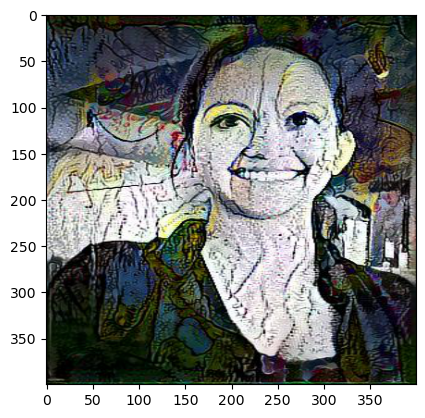

In [276]:
         
train_genC = train_generatorC(batch_size=5)
X_trainC, Y_trainC = next(train_genC)
print(X_trainC.shape)
print(Y_trainC.shape)

imgC = X_trainC[0,:,:,:]
plt.imshow(imgC)

imgC = Y_trainC[0,:,:,:]
plt.imshow(imgC)

plt.show()
plt.show()

In [277]:

def val_generatorC(batch_size=5):
    
    while True:
        
        # load the data in chunks (batches) from  ** df_val.csv.gz **
        for dfC in pd.read_csv('df_valC.csv', chunksize=batch_size):
            
            # get the list of portrait images
            image_id_listC = list(dfC['image_id'])
            # get list of art images
            art_id_listC = list(dfC['image_id'])
            
            
            # X_val
            # =========
            
            # create an empty matrix
            X_valC = np.zeros((len(dfC), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)


            for iC, image_id in enumerate(image_id_listC):

                # select the folder_id from the list
                folder_idC = image_id.split('-')[0]

                # set the path to the image
                pathC = '/Users/adeella/Desktop/project/aisegmentcom-matting-human-datasets/matting_human_half/clip_img/' + \
                str(folder_idC) + '/clip_00000000/' + image_id

                # read the file as an array
                imageC = plt.imread(pathC)
                # resize the image
                imageC = resize(imageC, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)


                # insert the image into X_val
                X_valC[iC] = imageC
                
            
            
            # Y_val
            # =========
            
            
            # create an empty matrix
            Y_valC = np.zeros((len(dfC), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)


            for iC, image_id in enumerate(art_id_listC):

                # set the path to the image
                pathC = '/Users/adeella/Desktop/project/art-by-ai-neural-style-transfer/content_images/content_images/' + image_id

                # read the file as an array
                #image = imread(path)
                # read the image using skimage
                imageC = imread(pathC)
                # resize the image
                imageC = resize(imageC, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

                # insert the image into X_val
                Y_valC[iC] = imageC
        
        
            yield X_valC, Y_valC
      

(5, 400, 400, 3)
(5, 400, 400, 3)


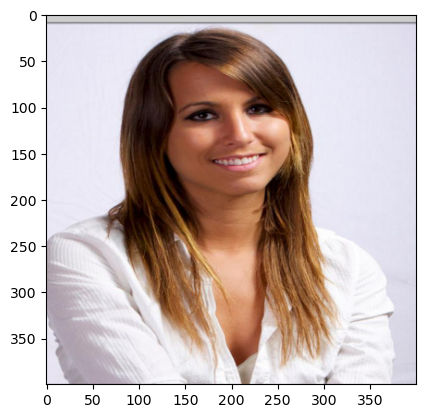

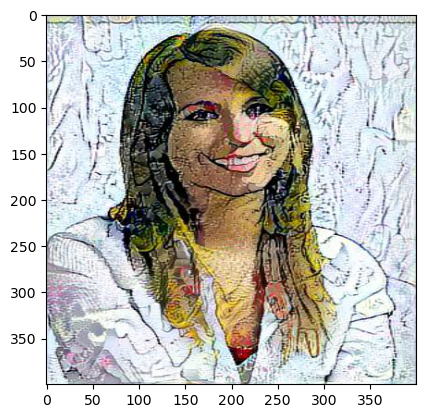

In [278]:
val_genC = val_generatorC(batch_size=5)

X_valC, Y_valC = next(val_genC)

print(X_valC.shape)
print(Y_valC.shape)

imgC = X_valC[0,:,:,:]
plt.imshow(imgC)

plt.show()

imgC = Y_valC[0,:,:,:]
plt.imshow(imgC)

plt.show()


In [279]:

def test_generatorC(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches) from  ** df_test.csv.gz **
        for dfC in pd.read_csv('df_testC.csv', chunksize=batch_size):
            
            # get the list of portrait images
            image_id_listC = list(dfC['image_id'])
            
            
            # X_test
            # =========
            
            # create an empty matrix
            X_testC = np.zeros((len(dfC), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=IMG_DTYPE)


            for iC, image_id in enumerate(image_id_listC):

                # select the folder_id from the list
                folder_idC = image_id.split('-')[0]

                # set the path to the image
                pathC = '/Users/adeella/Desktop/project/aisegmentcom-matting-human-datasets/matting_human_half/clip_img/' + \
                str(folder_idC) + '/clip_00000000/' + image_id

                # read the file as an array
                imageC = imread(pathC)
                # resize the image
                imageC = resize(imageC, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)


                # insert the image into X_test
                X_testC[iC] = imageC
                
            
            yield X_testC
            

In [280]:

modelC = Model(inputs=[inputs], outputs=[outputs])


modelC.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_180 (Conv2D)            (None, 400, 400, 16  448         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_90 (Dropout)           (None, 400, 400, 16  0           ['conv2d_180[0][0]']             
                                )                                                           

In [281]:
modelC.compile(Adam(lr=LEARNING_RATE), loss='mean_squared_error')

historyC = modelC.fit_generator(train_genC, steps_per_epoch=train_stepsC, epochs=10, validation_data=val_genC, validation_steps=val_steps,verbose=1)


Epoch 1/10
1620/1620 [==============================] - 7053s 4s/step - loss: 1237.8254 - val_loss: 1230.0264
Epoch 2/10
1620/1620 [==============================] - 7459s 5s/step - loss: 1148.0557 - val_loss: 1173.4413
Epoch 3/10
1620/1620 [==============================] - 7571s 5s/step - loss: 1116.3969 - val_loss: 1154.3535
Epoch 4/10
1620/1620 [==============================] - 7715s 5s/step - loss: 1098.0298 - val_loss: 1144.2103
Epoch 5/10
1620/1620 [==============================] - 7805s 5s/step - loss: 1085.8665 - val_loss: 1137.3420
Epoch 6/10
1620/1620 [==============================] - 7616s 5s/step - loss: 1076.7101 - val_loss: 1134.8516
Epoch 7/10
1620/1620 [==============================] - 7598s 5s/step - loss: 1070.4968 - val_loss: 1131.8497
Epoch 8/10
1620/1620 [==============================] - 7478s 5s/step - loss: 1063.4487 - val_loss: 1118.8481
Epoch 9/10
1620/1620 [==============================] - 7278s 4s/step - loss: 1058.3140 - val_loss: 1121.9525
Epoch 10/1

In [282]:


# initialize the test generator
test_genC = test_generatorC(batch_size=1)
predsC = modelC.predict_generator(test_genC, 
                                steps=len(df_testC), 
                                verbose=1)

# check the max and min predicted pixel values
print('\n')
print(predsC.max())
print(predsC.min())

predsC = np.clip(predsC, 0, 255).astype(IMG_DTYPE)


# check the max and min predicted pixel values again
print(predsC.max())
print(predsC.min())
######


10/10 [==============================] - 2s 140ms/step


268.93192
0.0
255
0


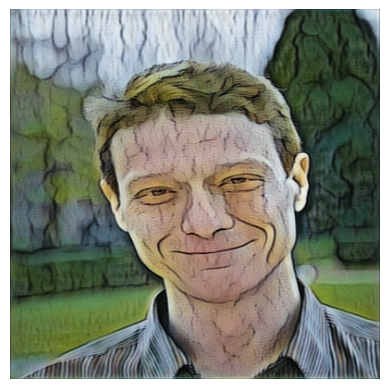

In [297]:

# image

imageC = predsC[1]
plt.imshow(imageC)
plt.axis('off')

plt.show()#


In [298]:
test_genC = test_generatorB(batch_size=1)
predsC = modelC.predict_generator(test_genC, 
                                steps=len(df_testC), 
                                verbose=1)


10/10 [==============================] - 2s 139ms/step


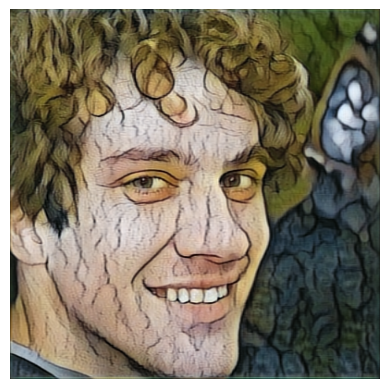

In [301]:
# image
predsC = np.clip(predsC, 0, 255).astype(IMG_DTYPE)
imageC = predsC[2]
plt.imshow(imageC)
plt.axis('off')

plt.show()#

Model 4 :
    
    make style images using art photo 

In [28]:
pip install tensorflow_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 1.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


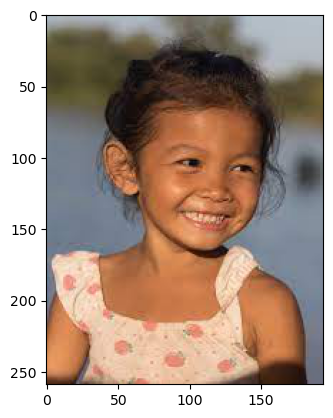

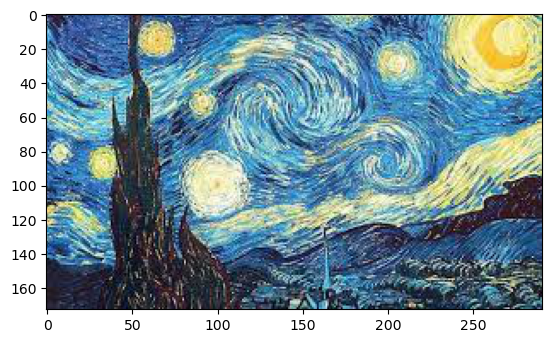

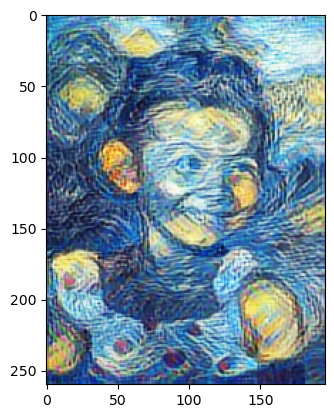

In [31]:
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
def load_image(img_path):
    img=tf.io.read_file(img_path)
    img= tf.image.decode_image(img,channels=(3))
    img=tf.image.convert_image_dtype(img,tf.float32)
    img=img[tf.newaxis,:]
    return img

content_image=load_image('/Users/adeella/Desktop/girl.jpeg')
style_image=load_image('/Users/adeella/Desktop/Unknown.jpeg')

plt.imshow(np.squeeze(content_image))
plt.show()

plt.imshow(np.squeeze(style_image))
plt.show()

stylized_image=model(tf.constant(content_image),tf.constant(style_image))[0]

plt.imshow(np.squeeze(stylized_image))
plt.show()
